In [1]:
import pandas as pd
import json

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import Normalize
import seaborn as sns; sns.set()

import networkx as nx
from pyvis.network import Network

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
nltk.download('punkt'); nltk.download('stopwords')
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from wordcloud import WordCloud

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\asher\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\asher\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data Wrangling
I want to figure out where Islamaphobic tweets are originating from (which tweets, users, etc) as well as what factors contribute to responses to these tweets.

The given dataset comes with  a lot of excess columns so I will try to extract the relevant data.

In [2]:
df = pd.read_csv('./noislamophobia-dataset-75k.csv')
df.head()

,_id,contributors,coordinates,created_at,entities,extended_entities,favorite_count,favorited,geo,id,...,quoted_status_id_str,retweet_count,retweeted,retweeted_status,source,text,full_text,truncated,user,withheld_in_countries
0,ObjectId(59dbede4e6e465a2d67a1062),NaN,NaN,Sun Oct 22 10:34:06 +0000 2017,"{""hashtags"":[{""text"":""BanIslam"",""indices"":[93,...",NaN,0,False,NaN,9.220484e+17,...,NaN,4,False,"{""created_at"":""Fri Oct 20 09:33:45 +0000 2017""...","<a href=""http://twitter.com/download/iphone"" r...",RT @Private34349909: @AmyMek @Dab7One 1/ @real...,NaN,False,"{""id"":8.009259051368776e+17,""id_str"":""80092590...",NaN
1,ObjectId(59dbede4e6e465a2d67a1068),NaN,NaN,Sun Oct 22 08:50:43 +0000 2017,"{""hashtags"":[{""text"":""RT"",""indices"":[38,41]},{...",NaN,0,False,NaN,9.220224e+17,...,NaN,9,False,"{""created_at"":""Sun Oct 22 00:40:33 +0000 2017""...","<a href=""http://twitter.com/#!/download/ipad"" ...",RT @PoliticalIslam: Educate yourself! #RT http...,NaN,False,"{""id"":42565769,""id_str"":""42565769"",""name"":""Epi...","[""DE""]"
2,ObjectId(59dbede4e6e465a2d67a1079),NaN,NaN,Sun Oct 22 10:28:09 +0000 2017,"{""hashtags"":[],""symbols"":[],""user_mentions"":[{...",NaN,0,False,NaN,9.220469e+17,...,9.216456e+17,0,False,NaN,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...","Say, @CanadianPM @JustinTrudeau @liberal_party...",NaN,True,"{""id"":1461022464,""id_str"":""1461022464"",""name"":...",NaN
3,ObjectId(59dbee5ce6e465a2d67a16b7),NaN,NaN,Sun Oct 22 10:12:59 +0000 2017,"{""hashtags"":[{""text"":""BanTippuJayanti"",""indice...",NaN,0,False,NaN,9.220431e+17,...,7.951297e+17,3,False,"{""created_at"":""Sun Nov 06 06:56:48 +0000 2016""...","<a href=""http://twitter.com/download/iphone"" r...",RT @ensine: Another reason KHANgressi govt mus...,NaN,False,"{""id"":142379064,""id_str"":""142379064"",""name"":""ॐ...",NaN
4,ObjectId(59dbee5ce6e465a2d67a16be),NaN,NaN,Sun Oct 22 10:35:20 +0000 2017,"{""hashtags"":[],""symbols"":[],""user_mentions"":[{...",NaN,0,False,NaN,9.220487e+17,...,NaN,0,False,NaN,"<a href=""http://twitter.com/download/android"" ...",@NathanHensley19 @davidholman82 @barry206 @Sky...,NaN,True,"{""id"":8.88537147011158e+17,""id_str"":""888537147...",NaN


In [3]:
df.columns

Index(['_id', 'contributors', 'coordinates', 'created_at', 'entities',
       'extended_entities', 'favorite_count', 'favorited', 'geo', 'id',
       'id_str', 'in_reply_to_screen_name', 'in_reply_to_status_id',
       'in_reply_to_status_id_str', 'in_reply_to_user_id',
       'in_reply_to_user_id_str', 'is_quote_status', 'lang', 'metadata',
       'place', 'possibly_sensitive', 'quoted_status', 'quoted_status_id',
       'quoted_status_id_str', 'retweet_count', 'retweeted',
       'retweeted_status', 'source', 'text', 'full_text', 'truncated', 'user',
       'withheld_in_countries'],
      dtype='object')

In [4]:
df[['user', 'in_reply_to_screen_name', 'in_reply_to_status_id', 'in_reply_to_user_id_str']]

,user,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_user_id_str
0,"{""id"":8.009259051368776e+17,""id_str"":""80092590...",NaN,NaN,NaN
1,"{""id"":42565769,""id_str"":""42565769"",""name"":""Epi...",NaN,NaN,NaN
2,"{""id"":1461022464,""id_str"":""1461022464"",""name"":...",NaN,NaN,NaN
3,"{""id"":142379064,""id_str"":""142379064"",""name"":""ॐ...",NaN,NaN,NaN
4,"{""id"":8.88537147011158e+17,""id_str"":""888537147...",NathanHensley19,9.218437e+17,8.691169e+17
...,...,...,...,...
75128,"{""id"":9.41763230644523e+17,""id_str"":""941763230...",NaN,NaN,NaN
75129,"{""id"":427370852,""id_str"":""427370852"",""name"":""J...",NaN,NaN,NaN
75130,"{""id"":2.392458824e+09,""id_str"":""2392458824"",""n...",NaN,NaN,NaN
75131,"{""id"":721263993,""id_str"":""721263993"",""name"":""H...",NaN,NaN,NaN


In [5]:
df.in_reply_to_screen_name.notna().sum()

7262

In [6]:
# Get a username column
df.user[0]

'{"id":8.009259051368776e+17,"id_str":"800925905136877569","name":"Cl_USARocks 🇺🇸","screen_name":"usarocks_c","location":"United States","description":"Grateful 4 Trump fam! Support Trump 100%! Thank U Vets, Police, BP \\u0026 All Who Protect Us!🙏🏻 I stand!🇺🇸 #MAGA🚫NFL 🚫Islam 🚫Sharia Law 🚫No Flirt DM’s👈🏻","url":"https://t.co/LiQOFDfZgS","entities":{"url":{"urls":[{"url":"https://t.co/LiQOFDfZgS","expanded_url":"http://www.Happily.Married.2.Vet","display_url":"Happily.Married.2.Vet","indices":[0,23]}]},"description":{"urls":[]}},"protected":false,"followers_count":10789,"friends_count":10761,"listed_count":21,"created_at":"Tue Nov 22 04:56:31 +0000 2016","favourites_count":21130,"utc_offset":null,"time_zone":null,"geo_enabled":false,"verified":false,"statuses_count":14405,"lang":"en","contributors_enabled":false,"is_translator":false,"is_translation_enabled":false,"profile_background_color":"F5F8FA","profile_background_image_url":null,"profile_background_image_url_https":null,"profile_b

In [7]:
origin = df[['user', 'in_reply_to_screen_name', 'retweet_count', 'retweeted', 'created_at', 'text']]
origin.head()

,user,in_reply_to_screen_name,retweet_count,retweeted,created_at,text
0,"{""id"":8.009259051368776e+17,""id_str"":""80092590...",NaN,4,False,Sun Oct 22 10:34:06 +0000 2017,RT @Private34349909: @AmyMek @Dab7One 1/ @real...
1,"{""id"":42565769,""id_str"":""42565769"",""name"":""Epi...",NaN,9,False,Sun Oct 22 08:50:43 +0000 2017,RT @PoliticalIslam: Educate yourself! #RT http...
2,"{""id"":1461022464,""id_str"":""1461022464"",""name"":...",NaN,0,False,Sun Oct 22 10:28:09 +0000 2017,"Say, @CanadianPM @JustinTrudeau @liberal_party..."
3,"{""id"":142379064,""id_str"":""142379064"",""name"":""ॐ...",NaN,3,False,Sun Oct 22 10:12:59 +0000 2017,RT @ensine: Another reason KHANgressi govt mus...
4,"{""id"":8.88537147011158e+17,""id_str"":""888537147...",NathanHensley19,0,False,Sun Oct 22 10:35:20 +0000 2017,@NathanHensley19 @davidholman82 @barry206 @Sky...


In [8]:
# want to get username, user_id_str, followers_count, verified out of 'user'
user_df = origin.user.apply(json.loads).apply(pd.Series)
user_df.head()

,id,id_str,name,screen_name,location,description,url,entities,protected,followers_count,...,profile_text_color,profile_use_background_image,has_extended_profile,default_profile,default_profile_image,following,follow_request_sent,notifications,translator_type,withheld_in_countries
0,8.009259e+17,800925905136877569,Cl_USARocks 🇺🇸,usarocks_c,United States,Grateful 4 Trump fam! Support Trump 100%! Than...,https://t.co/LiQOFDfZgS,{'url': {'urls': [{'url': 'https://t.co/LiQOFD...,False,10789,...,333333,True,False,True,False,False,False,False,none,NaN
1,4.256577e+07,42565769,Epicurist,Demontialto,Australia,"Atheist, Free thinker hopefully. RT not necess...",None,{'description': {'urls': []}},False,623,...,000000,False,False,False,False,False,False,False,none,NaN
2,1.461022e+09,1461022464,Steers Mann,SteersMann,"BC, Canada",Retired electronics technologist; proponent of...,None,{'description': {'urls': [{'url': 'https://t.c...,False,787,...,333333,True,False,True,False,False,False,False,none,NaN
3,1.423791e+08,142379064,ॐ भारत ॐ,_dharam_vir,हिन्दू राष्ट्र भारत,धृति: क्षमा दमोऽस्‍तेयं शौचमिन्‍द्रियनिग्रह: ।...,https://t.co/P8k1D0FqWN,{'url': {'urls': [{'url': 'https://t.co/P8k1D0...,False,21211,...,333333,True,False,False,False,False,False,False,none,NaN
4,8.885371e+17,888537147011158017,Guy Fawkes,Anonymo95592895,,,None,{'description': {'urls': []}},False,29,...,333333,True,False,True,False,False,False,False,none,NaN


In [9]:
user_df.columns

Index(['id', 'id_str', 'name', 'screen_name', 'location', 'description', 'url',
       'entities', 'protected', 'followers_count', 'friends_count',
       'listed_count', 'created_at', 'favourites_count', 'utc_offset',
       'time_zone', 'geo_enabled', 'verified', 'statuses_count', 'lang',
       'contributors_enabled', 'is_translator', 'is_translation_enabled',
       'profile_background_color', 'profile_background_image_url',
       'profile_background_image_url_https', 'profile_background_tile',
       'profile_image_url', 'profile_image_url_https', 'profile_banner_url',
       'profile_link_color', 'profile_sidebar_border_color',
       'profile_sidebar_fill_color', 'profile_text_color',
       'profile_use_background_image', 'has_extended_profile',
       'default_profile', 'default_profile_image', 'following',
       'follow_request_sent', 'notifications', 'translator_type',
       'withheld_in_countries'],
      dtype='object')

In [10]:
origin['id_str'] = user_df.id_str
origin['username'] = user_df.screen_name
origin['followers_count'] = user_df.followers_count
origin['verified'] = user_df.verified
origin = origin[['username', 'id_str', 'followers_count', 'verified', 'in_reply_to_screen_name', 'retweet_count', 'retweeted', 'text', 'created_at']]
origin.head()

,username,id_str,followers_count,verified,in_reply_to_screen_name,retweet_count,retweeted,text,created_at
0,usarocks_c,800925905136877569,10789,False,NaN,4,False,RT @Private34349909: @AmyMek @Dab7One 1/ @real...,Sun Oct 22 10:34:06 +0000 2017
1,Demontialto,42565769,623,False,NaN,9,False,RT @PoliticalIslam: Educate yourself! #RT http...,Sun Oct 22 08:50:43 +0000 2017
2,SteersMann,1461022464,787,False,NaN,0,False,"Say, @CanadianPM @JustinTrudeau @liberal_party...",Sun Oct 22 10:28:09 +0000 2017
3,_dharam_vir,142379064,21211,False,NaN,3,False,RT @ensine: Another reason KHANgressi govt mus...,Sun Oct 22 10:12:59 +0000 2017
4,Anonymo95592895,888537147011158017,29,False,NathanHensley19,0,False,@NathanHensley19 @davidholman82 @barry206 @Sky...,Sun Oct 22 10:35:20 +0000 2017


In [11]:
# The retweeted column is always false, so recalculate it
origin.retweeted = origin.text.str.startswith('RT')
print(f'Number of tweets that are RTs: {origin.retweeted.sum()}')

# created_at column is not of type datetime
origin.created_at = pd.to_datetime(origin.created_at)

origin[origin.retweeted].head()

Number of tweets that are RTs: 57505


,username,id_str,followers_count,verified,in_reply_to_screen_name,retweet_count,retweeted,text,created_at
0,usarocks_c,800925905136877569,10789,False,NaN,4,True,RT @Private34349909: @AmyMek @Dab7One 1/ @real...,2017-10-22 10:34:06+00:00
1,Demontialto,42565769,623,False,NaN,9,True,RT @PoliticalIslam: Educate yourself! #RT http...,2017-10-22 08:50:43+00:00
3,_dharam_vir,142379064,21211,False,NaN,3,True,RT @ensine: Another reason KHANgressi govt mus...,2017-10-22 10:12:59+00:00
5,IFoundThatThis,2835196635,12,False,NaN,46,True,RT @Anni_Cyrus: 963 under 10 yr child brides i...,2017-10-22 08:11:44+00:00
6,SithJeep,2180717723,1143,False,NaN,46,True,RT @Anni_Cyrus: 963 under 10 yr child brides i...,2017-10-22 10:20:06+00:00


# Data Exploration
I now have the dataframe origin which has the username and some potential measures for how popular the user is and how much "penetration potential" their tweets have.

Will now begin to explore the data.

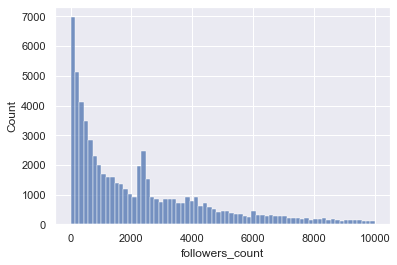

In [12]:
sns.histplot(data=origin, x='followers_count', binrange=(0, 10000))

In [13]:
origin[origin.verified]

,username,id_str,followers_count,verified,in_reply_to_screen_name,retweet_count,retweeted,text,created_at
4380,se4realhinton,313454492,47640,True,NaN,58,True,RT @DoraDoubleDD: Let’s first see if the dude ...,2017-11-05 22:02:31+00:00
6007,raistolo,526837239,5207,True,NaN,12,True,RT @chedisagio: Ricordate questa foto?\ne l'ha...,2017-11-14 13:38:58+00:00
9456,FDW_VB,142646856,18357,True,NaN,11,False,Antwerpse #VlaamsBelang parlementsleden plakke...,2017-12-04 12:15:09+00:00
9881,jjauthor,177584156,171831,True,NaN,12,True,RT @khalifallah: I'm an #ExMuslimBecause civil...,2017-12-07 04:14:36+00:00
12007,Shastina_Eloff,26183714,139795,True,NaN,8,True,RT @InTheYear1611_: @Lovin2Laugh A few things ...,2017-12-18 02:46:18+00:00
18085,medenix,202762476,2182,True,NaN,1,True,"RT @vlwigg: ""I find this disgraceful post abho...",2018-02-14 22:06:53+00:00
18091,NanetteLight,44390647,647,True,NaN,6,True,"RT @vlwigg: ""I find this disgraceful post abho...",2018-02-14 22:34:58+00:00
18114,disolis,15996671,4787,True,NaN,8,True,RT @omarsuleiman504: Grateful to Plano Mayor H...,2018-02-15 02:43:12+00:00
20062,itsYourGrace,570567264,4385,True,NaN,407,True,RT @WayneDupreeShow: This Sheriff should share...,2018-03-08 16:13:38+00:00
23807,AliceOllstein,55790584,15113,True,NaN,103,True,RT @KFILE: NEW: Political appointee at HHS sha...,2018-04-13 20:12:09+00:00


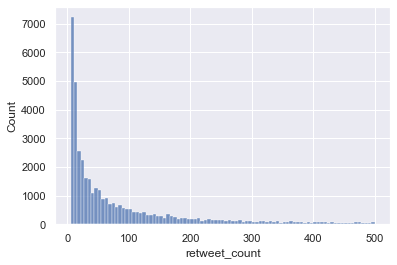

In [14]:
# I excludes tweets with < 5 retweets since they are a clear majority and mess up the scale of the graph
sns.histplot(data=origin, x='retweet_count', binrange=(5, 500))

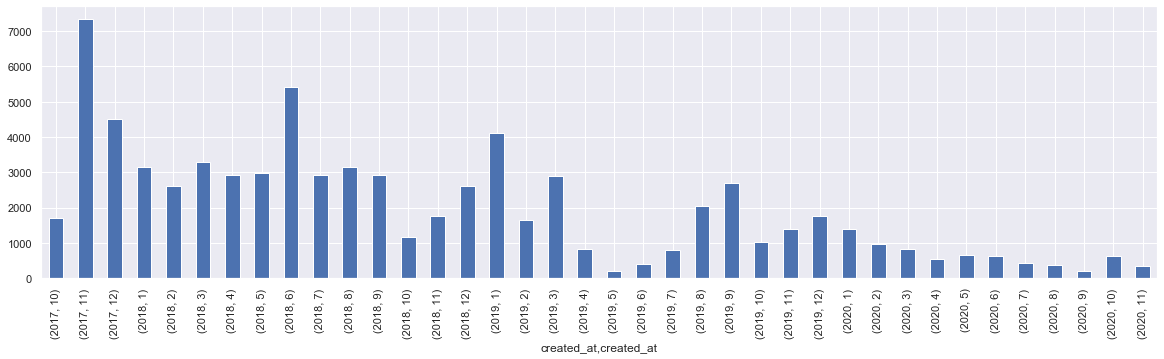

In [15]:
origin.groupby([origin.created_at.dt.year, origin.created_at.dt.month])['username'].count().plot(kind='bar', figsize=(20, 5))

## Initial Conclusions
- Most of the people tweeting in this dataset have very few followers. The distribution of followers is highest at 0 with an exponential dropoff for larger amounts of followers.
- There are very few verified users (around 28). These users obviously have a high amount of followers compared to other users.
- These verified users are retweeted a lot. The retweet_count distribution has an exponential dropoff and all of these verified users have retweet_counts much higher than shown in the retweet_count histogram.
- Verified users also retweet others a lot. This was not properly indicated in the retweeted column, so I recalculated it.
- Most of our tweets come from late 2017 - 2018 with fewer tweets in 2019 and 2020. November 2017 had a particularly high amount of tweets, might be interesting to see why that is.

# Word Cloud
Show which words are the most popular to get a general idea of what people are tweeting about.

In [16]:
# Read in combined dataframe
df_50k = pd.read_csv('./noislamophobia-dataset-50k.csv')
df_75k = pd.read_csv('./noislamophobia-dataset-75k.csv')
df = pd.concat([df_50k,df_75k])

# Filter out words that start with things in filter_list or any stopwords
filter_list = ['@', '#', 'http', 'rt', '&', 'islam', 'muslim', 'religion', 'don', 'need', 'know']
stops = set(stopwords.words('english'))

def good_wd(wd):
    return not any(wd.lower().startswith(x) for x in filter_list) and wd not in stops

# Clean up tweets
tweets = df.text.dropna().str.split().apply(lambda lst: ' '.join(filter(good_wd, lst)))

# Generate word cloud
wordcloud = WordCloud().generate(' '.join(tweets))
image = wordcloud.to_image()
image.save('wordcloud.png')

![wordcloud](./wordcloud.png)

# Penetration Network
At this point, it seems clear that verified users have much higher Twitter penetration since they are much more involved in the process of retweeting as well as being retweeted. There are not many verified users in this dataset so I will also be looking at users with a high amount of followers. I will try to visualize how tweets from these users spread and what factors influence this spread.

In [17]:
# Get a column that has all the @'d users for that tweet
origin['mentions'] = origin.text.str.split().apply(lambda lst: [(x[1:-1] if x.endswith(':') else x[1:]) for x in filter(lambda x: x.startswith('@'), lst)])
origin.head()

,username,id_str,followers_count,verified,in_reply_to_screen_name,retweet_count,retweeted,text,created_at,mentions
0,usarocks_c,800925905136877569,10789,False,NaN,4,True,RT @Private34349909: @AmyMek @Dab7One 1/ @real...,2017-10-22 10:34:06+00:00,"[Private34349909, AmyMek, Dab7One, realDonaldT..."
1,Demontialto,42565769,623,False,NaN,9,True,RT @PoliticalIslam: Educate yourself! #RT http...,2017-10-22 08:50:43+00:00,"[PoliticalIslam, PoliticalIslam]"
2,SteersMann,1461022464,787,False,NaN,0,False,"Say, @CanadianPM @JustinTrudeau @liberal_party...",2017-10-22 10:28:09+00:00,"[CanadianPM, JustinTrudeau, liberal_party,]"
3,_dharam_vir,142379064,21211,False,NaN,3,True,RT @ensine: Another reason KHANgressi govt mus...,2017-10-22 10:12:59+00:00,[ensine]
4,Anonymo95592895,888537147011158017,29,False,NathanHensley19,0,False,@NathanHensley19 @davidholman82 @barry206 @Sky...,2017-10-22 10:35:20+00:00,"[NathanHensley19, davidholman82, barry206, Sky..."


In [18]:
cols = ['username', 'followers_count', 'retweet_count', 'mentions']

# Aggregate users to count their average num of followers, total retweets, and total mentions
graph_df = origin[cols].groupby('username').agg({'followers_count': 'mean', 'retweet_count': 'sum', 'mentions': 'sum'}).reset_index()

# Will use follower count to represent node size; scale them between sizes [1000, 51000] for the network
graph_df['scaled_count'] = 1000 + (graph_df.followers_count - graph_df.followers_count.min()) * 50000 / (graph_df.followers_count.max() - graph_df.followers_count.min())

# Explode df on mentions to add in edges
graph_df = graph_df.explode('mentions')

# Add underscore to usernames and mentions so they aren't treated as ints by the library
graph_df.username = graph_df.username + '_'
graph_df.mentions = graph_df.mentions + '_'

# Calculate hex color codes so that higher retweet count corresponds to darker red node
norm = Normalize(vmin=0, vmax=5000, clip=True)
mapper = plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.Reds)
graph_df['colors'] = graph_df.retweet_count.apply(lambda x: mcolors.to_hex(mapper.to_rgba(x)))

graph_df.head()

,username,followers_count,retweet_count,mentions,scaled_count,colors
0,0000DD02_,3000.0,3,76rooster_,1203.042204,#fff5f0
1,000_Gopal32_,2410.0,215,Donotshit_,1163.110570,#ffeee6
2,001Nationalist_,60.0,2,NaN,1004.060844,#fff5f0
3,001_rhonda_,994.0,508,yeatsfeats_,1067.274650,#fee4d8
3,001_rhonda_,994.0,508,JoeBelsha1_,1067.274650,#fee4d8


In [19]:
# More red = More retweets, Larger = More followers
nodes = graph_df.head(500).drop_duplicates('username')
mentions = [x for x in graph_df.head(500).mentions.dropna() if x not in nodes.username]
title_col = 'Followers: ' + nodes.followers_count.astype(int).astype(str) + '\nRetweets: ' + nodes.retweet_count.astype(str)

nt = Network(height=800, width='100%', notebook=True, directed=True)
nt.add_nodes(nodes.username.to_numpy(), title=title_col, value=nodes.scaled_count, color=nodes.colors)
nt.add_nodes(mentions, title=mentions, value=[50] * len(mentions), color=['#FFFFFF'] * len(mentions))
nt.add_edges(graph_df[['username', 'mentions']].head(500).dropna().to_records(index=False))

nt.show('pen_network.html')

# Sentiment Analysis
I will be using the VADER Sentiment Analysis library since it works well on emojis and slang. This library also uses NLTK under the hood for parsing out stop words. This will generate a score for each tweet from -1 to 1.
- Score < -0.05: Negative Sentiment
- Score > 0.05: Positive Sentiment
- -0.05 <= Score <= 0.05: Neutral Sentiment

In [20]:
origin.head()

,username,id_str,followers_count,verified,in_reply_to_screen_name,retweet_count,retweeted,text,created_at,mentions
0,usarocks_c,800925905136877569,10789,False,NaN,4,True,RT @Private34349909: @AmyMek @Dab7One 1/ @real...,2017-10-22 10:34:06+00:00,"[Private34349909, AmyMek, Dab7One, realDonaldT..."
1,Demontialto,42565769,623,False,NaN,9,True,RT @PoliticalIslam: Educate yourself! #RT http...,2017-10-22 08:50:43+00:00,"[PoliticalIslam, PoliticalIslam]"
2,SteersMann,1461022464,787,False,NaN,0,False,"Say, @CanadianPM @JustinTrudeau @liberal_party...",2017-10-22 10:28:09+00:00,"[CanadianPM, JustinTrudeau, liberal_party,]"
3,_dharam_vir,142379064,21211,False,NaN,3,True,RT @ensine: Another reason KHANgressi govt mus...,2017-10-22 10:12:59+00:00,[ensine]
4,Anonymo95592895,888537147011158017,29,False,NathanHensley19,0,False,@NathanHensley19 @davidholman82 @barry206 @Sky...,2017-10-22 10:35:20+00:00,"[NathanHensley19, davidholman82, barry206, Sky..."


In [21]:
sent = SentimentIntensityAnalyzer()
origin['sentiment'] = origin.text.apply(lambda s: sent.polarity_scores(s)['compound'])
origin.head()

,username,id_str,followers_count,verified,in_reply_to_screen_name,retweet_count,retweeted,text,created_at,mentions,sentiment
0,usarocks_c,800925905136877569,10789,False,NaN,4,True,RT @Private34349909: @AmyMek @Dab7One 1/ @real...,2017-10-22 10:34:06+00:00,"[Private34349909, AmyMek, Dab7One, realDonaldT...",0.4648
1,Demontialto,42565769,623,False,NaN,9,True,RT @PoliticalIslam: Educate yourself! #RT http...,2017-10-22 08:50:43+00:00,"[PoliticalIslam, PoliticalIslam]",0.0000
2,SteersMann,1461022464,787,False,NaN,0,False,"Say, @CanadianPM @JustinTrudeau @liberal_party...",2017-10-22 10:28:09+00:00,"[CanadianPM, JustinTrudeau, liberal_party,]",0.0000
3,_dharam_vir,142379064,21211,False,NaN,3,True,RT @ensine: Another reason KHANgressi govt mus...,2017-10-22 10:12:59+00:00,[ensine],0.0000
4,Anonymo95592895,888537147011158017,29,False,NathanHensley19,0,False,@NathanHensley19 @davidholman82 @barry206 @Sky...,2017-10-22 10:35:20+00:00,"[NathanHensley19, davidholman82, barry206, Sky...",-0.8922


In [22]:
# Five worst sentiment tweets
list(origin.sort_values('sentiment').text[:5])

['@potus WE HAVE A #terrorism problem \nAmerica will NEVER submit to 🚫#Islam \n😠😠😠😠😠😠😠😠😠😠😠 @ICEgov @SecretService @FBI… https://t.co/LTzitgKuJk',
 '#Sweden :  #Girl #gang #raped , #VAGINA SET ON #FIRE 😠😠😠😠😠😠😠😠\n#EnoughIsEnough \nSTOP #rapeculture\nSTOP #CARNAGE… https://t.co/Lax7gOkkze',
 'RT @Chris_A10_USA: #Ireland 🇮🇪: #Muslim #migrant charged in random #stabbing #murder, Gardai still say no link to #terrorism 😠😠😠😠😠\n#BanShar…',
 'RT @Greeneyz0080: @IlhanMN Forgot these, cupcake. You’re welcome.\n#BanIslam #islamistheproblem\n👿👿👿👿👿👿👿👿👿 https://t.co/4IwIZzwwuD',
 '@IlhanMN Forgot these, cupcake. You’re welcome.\n#BanIslam #islamistheproblem\n👿👿👿👿👿👿👿👿👿 https://t.co/4IwIZzwwuD']

In [23]:
# Five best sentiment tweets
list(origin.sort_values('sentiment', ascending=False).text[:5])

['Goodnight friends \n🇳🇱🇳🇱🇳🇱🇳🇱🇳🇱🇳🇱🇳🇱\n♥️♥️♥️♥️♥️♥️♥️\n🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸\n♥️♥️♥️♥️♥️♥️♥️\n#Trump \n#TrumpLandslide2020… https://t.co/w7k752m9Dj',
 'RT @BoondockCat: @WindowFixed @Ilhan 🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣\nWhere are all the moderates\nwhen you need them!\n\nMuslim women, children, &amp; gays\nbeing raped…',
 '@BreitbartNews @shash1026 😂😂😂😂😂😂😂😂😂😂😂. Oh no, we don’ t biatch,  YOU ALONE ARE RESPONSIBLE FOR THEM BEING IN CONGRE… https://t.co/CzAgZzWYOC',
 'RT @mineisC: @BreitbartNews @shash1026 😂😂😂😂😂😂😂😂😂😂😂. Oh no, we don’ t biatch,  YOU ALONE ARE RESPONSIBLE FOR THEM BEING IN CONGRESS. YOU OWE…',
 '@matloobshah11 @Whiskey100Proof @TeamTrump @realDonaldTrump @thebbtcenter Honors and respects women? 😂😂😂😂😂😂😂😂😂 That… https://t.co/CnvzuUs1Dw']

In [24]:
# Five tweets with most neutral sentiment
list(origin.sort_values('sentiment', key=abs).text[:5])

['RT @Chris_A10_USA: 🇬🇧 #UK : #Muslim rams car into crowded nightclub, injuring 13 partygoers 😳😳😳\n#StopCarnage #ReligionOfPeace #Bansharia #B…',
 '@RajatSharmaLive So simple sir \nCoz #IslamIsTheProblem',
 'RT @Ru260566: #BanIslam https://t.co/Z4pTXrB7uI',
 'Again, Tell me why we should let them into America ! #BANSHARIA #EndDACA https://t.co/DEDYUZkIog https://t.co/emonDesiW5',
 'RT @UKInfidel: #IslamExposed: #Rapejihad in #Cambridge: Muslim Walks out of Court: https://t.co/6rEm1P9XVY\n\n#UK #Britain🇬🇧\n\n#Sunnah of #Ras…']

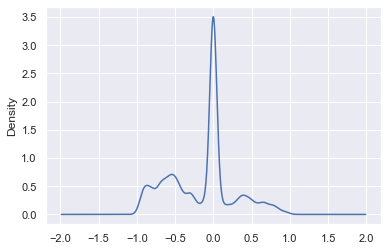

In [25]:
origin.sentiment.plot.kde()

This sentiment analysis is not perfect. It definitely does a better job detecting meaner tweets, but it seems to rely heavily on the type of emojis used since the top five all have angry emojis. The highest sentiment tweets are still quite Islamaphobic, but this is to be expected since this dataset primarily includes Islamaphobic tweets. Looking at the KDE plot of sentiment distribution, most tweets have been tagged with neutral sentiment. There is a higher peak of negative tweets in comparison to positive tweets which is a good sanity check.

# Bar Chart Race

In [1]:
import pandas as pd
import json
from collections import defaultdict, Counter
import datetime
from tqdm import tqdm
import bar_chart_race as bcr
import matplotlib.pyplot as plt

In [2]:
df_50k = pd.read_csv('../noislamophobia-dataset-50k.csv')
df_75k = pd.read_csv('../noislamophobia-dataset-75k.csv')
df = pd.concat([df_50k,df_75k])
df.head()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3018: DtypeWarning: Columns (2,8,32) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,_id,contributors,coordinates,created_at,entities,extended_entities,favorite_count,favorited,geo,id,...,quoted_status_id_str,retweet_count,retweeted,retweeted_status,source,text,full_text,truncated,user,withheld_in_countries
0,ObjectId(59dbede4e6e465a2d67a1062),NaN,NaN,Sun Oct 22 10:34:06 +0000 2017,"{""hashtags"":[{""text"":""BanIslam"",""indices"":[93,...",NaN,0,False,NaN,9.220484e+17,...,NaN,4,False,"{""created_at"":""Fri Oct 20 09:33:45 +0000 2017""...","<a href=""http://twitter.com/download/iphone"" r...",RT @Private34349909: @AmyMek @Dab7One 1/ @real...,NaN,False,"{""id"":8.009259051368776e+17,""id_str"":""80092590...",NaN
1,ObjectId(59dbede4e6e465a2d67a106c),NaN,NaN,Sun Oct 22 10:13:40 +0000 2017,"{""hashtags"":[{""text"":""muslim"",""indices"":[16,23...",NaN,0,False,NaN,9.220433e+17,...,NaN,10,False,"{""created_at"":""Sat Oct 21 18:37:07 +0000 2017""...","<a href=""http://twitter.com/download/android"" ...",RT @ensine: All #muslim rulers were savages bc...,NaN,False,"{""id"":375089876,""id_str"":""375089876"",""name"":""द...",NaN
2,ObjectId(59dbf266e6e465a2d67a4810),NaN,NaN,Sun Oct 22 07:50:47 +0000 2017,"{""hashtags"":[{""text"":""Raqqa"",""indices"":[37,43]...",NaN,0,False,NaN,9.220073e+17,...,NaN,172,False,"{""created_at"":""Fri Oct 20 23:15:45 +0000 2017""...","<a href=""http://twitter.com/download/android"" ...",RT @SLandinSoCal: Liberated Women of #Raqqa‼️R...,NaN,False,"{""id"":7.092975641898926e+17,""id_str"":""70929756...",NaN
3,ObjectId(59dbf266e6e465a2d67a4828),NaN,NaN,Sun Oct 22 10:38:23 +0000 2017,"{""hashtags"":[],""symbols"":[],""user_mentions"":[{...",NaN,0,False,NaN,9.220495e+17,...,NaN,1,False,NaN,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",@Stormtroepen @cdavandaag @sybrandbuma @gertja...,NaN,True,"{""id"":1340408646,""id_str"":""1340408646"",""name"":...",NaN
4,ObjectId(59e8e630e6e465a2d6238c9c),NaN,NaN,Sun Oct 22 08:59:53 +0000 2017,"{""hashtags"":[{""text"":""RT"",""indices"":[51,54]},{...",NaN,0,False,NaN,9.220247e+17,...,NaN,25,False,"{""created_at"":""Sun Oct 22 01:40:55 +0000 2017""...","<a href=""http://twitter.com/download/android"" ...",RT @PoliticalIslam: Sharia at odds with Articl...,NaN,False,"{""id"":150595824,""id_str"":""150595824"",""name"":""🇮...","[""DE""]"


In [3]:
df = df.drop_duplicates()
df_na = df.dropna(axis=1, thresh=.75)

In [4]:
table = defaultdict(int)

for entity in df['entities']:
    test = json.loads(entity)
    for x in test['hashtags']:
            table[x['text'].lower()] += 1
print(table)

defaultdict(<class 'int'>, {'banislam': 28780, 'deportallmuslims': 23, 'muslim': 5480, 'islamistheproblem': 8704, 'tyranttipu': 2, 'raqqa': 23, 'burqa': 26, 'islam': 6305, 'bansharia': 13500, 'rt': 1136, 'stopislam': 2660, 'tcot': 692, 'billwarnerphd': 838, 'makedclisten': 724, 'iran': 440, 'stopislamization': 368, 'hope4women': 193, 'jihad': 1606, 'uk': 4398, 'dianneabbott': 1, 'ejected': 1, 'assaulted': 1, 'iraqi': 2, 'british': 129, 'shariacantbelaw': 1, 'shariaviolatesuslaw': 2, 'cruelandunusual': 2, 'islamoutofusnow': 1, 'nousmosques': 8, 'merkles': 15, 'maga': 4156, 'wtf': 13, 'omg': 6, 'banthequranasahatebook': 70, 'bansharialaw': 4006, 'bandumbasshollywoodliars': 3, 'islamisacult': 107, 'cspi': 523, 'isupportpresidenttrump': 58, 'trump2020': 589, '1a': 155, '2a': 320, 'americafirst': 1471, 'nogozones': 55, 'buildthewall': 1666, 'everify': 4, 'deportthemall': 465, 'nomorerefugees': 27, 'pedophiles': 21, 'pedophilia': 33, 'politicalislam': 200, 'muhammad': 198, 'feminism': 11, 't

In [5]:
df_datetime = pd.to_datetime(df['created_at']).dt.date
df_datetime.head()

0    2017-10-22
1    2017-10-22
2    2017-10-22
3    2017-10-22
4    2017-10-22
Name: created_at, dtype: object

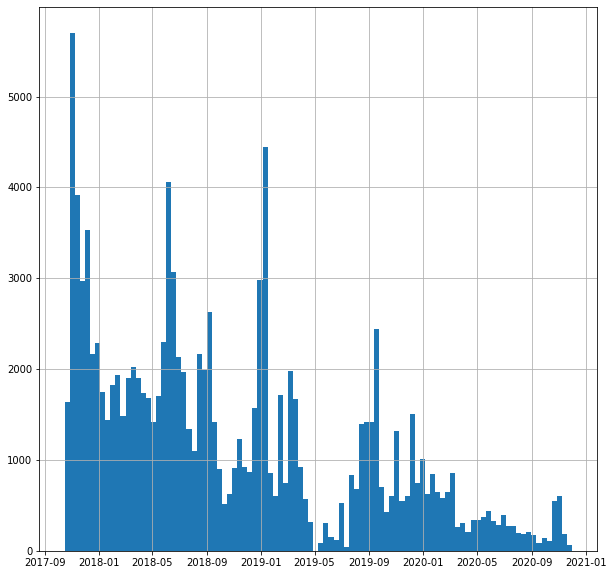

In [6]:
df_datetime.hist(figsize=(10,10), bins=100)
plt.show()

In [7]:
table = dict(sorted(table.items(), key=lambda item: item[1], reverse=True))
table

{'banislam': 28780,
 'bansharia': 13500,
 'islamistheproblem': 8704,
 'islam': 6305,
 'islamexposed': 6135,
 'muslim': 5480,
 'religionofpeace': 4469,
 'uk': 4398,
 'maga': 4156,
 'bansharialaw': 4006,
 'stopislam': 2660,
 'britain': 2512,
 'muslims': 2297,
 'buildthewall': 1666,
 'jihad': 1606,
 'americafirst': 1471,
 'religionbeliefs': 1298,
 'patriotic': 1294,
 'america': 1267,
 'wakeupamerica': 1234,
 'islamic': 1173,
 'rt': 1136,
 'rapejihad': 1096,
 'nosharia': 1051,
 'isis': 982,
 'stopcarnage': 964,
 'pvv': 937,
 'sharialaw': 908,
 'billwarnerphd': 838,
 'sharia': 827,
 'cair': 814,
 'islamicstate': 801,
 'kag': 760,
 'breaking': 751,
 'makedclisten': 724,
 'endislam': 716,
 'christian': 716,
 'tcot': 692,
 'educateyourselfonislam': 689,
 'terror': 678,
 'qanon': 651,
 'freetommy': 641,
 'muslimban': 639,
 'migrant': 631,
 'allah': 621,
 'usa': 619,
 'trump2020': 589,
 'freetommyrobinson': 586,
 'us': 580,
 'travelban': 577,
 'rape': 562,
 'france': 558,
 'immigrationreform': 5

In [8]:
new_df = df.copy()
new_df['date'] = pd.to_datetime(new_df['created_at']).dt.date
new_df.index = new_df['date']
new_df = new_df[['entities']]
new_df.head()

,entities
date,
2017-10-22,"{""hashtags"":[{""text"":""BanIslam"",""indices"":[93,..."
2017-10-22,"{""hashtags"":[{""text"":""muslim"",""indices"":[16,23..."
2017-10-22,"{""hashtags"":[{""text"":""Raqqa"",""indices"":[37,43]..."
2017-10-22,"{""hashtags"":[],""symbols"":[],""user_mentions"":[{..."
2017-10-22,"{""hashtags"":[{""text"":""RT"",""indices"":[51,54]},{..."


In [9]:
datetime_dict = defaultdict(lambda: defaultdict(dict))

def get_counts(entity):
    table = defaultdict(int)
    test = json.loads(entity)
    for x in test['hashtags']:
        table[x['text'].lower()] += 1
    return table
    

for idx, row in tqdm(new_df.iterrows()):
    datetime_dict[idx] = dict(Counter(datetime_dict[idx]) + Counter(get_counts(row['entities'])))

119019it [00:16, 7031.99it/s]


In [11]:
# df_bar_chart_race = pd.DataFrame.from_dict(datetime_dict,orient='index').fillna(value=0).cumsum()
# bcr.bar_chart_race(df = df_bar_chart_race.head(), 
#                    n_bars=5, 
#                    title = "Popular Hashtags (2017-2021)", 
#                    period_length=250,
#                    bar_kwargs={'alpha': .7},
#                    bar_label_size=7)

<video controls src="islamophobia.mp4" />

# Live Flagging

In [13]:
import twint
# grab the hashtags we want to track
table = defaultdict(int)

for entity in df['entities']:
    test = json.loads(entity)
    for x in test['hashtags']:
            table[x['text'].lower()] += 1

table = Counter(table)
table = dict(table.most_common(100))
remove  = ['islam', 'muslim', 'religionofpeace', 'uk', 'maga', 'britain', 'muslims', 'buildthewall', 'jihad', 'americafirst', 'religionbeliefs', 'patriotic', 'america', 'wakeupamerica', 'islamic', 'rt', 'stopcarnage', 'pvv', 'kag', 'breaking', 'makedclisten', 'christian',
'educateyourselfonislam', 'tcot', 'terror','freetommy', 'allah', 'migrant', 'usa', 'trump2020', 'travelban', 'us', 'freetommyrobinson', 'rape', 'immigrationreform', 'bannogozones', 'france', 'lilbulli', 'germany','draintheswamp', 'canada', 'europe','cspi','pakistan','trump','veterans', 'trumptrain', 'iran', 'bancair','ramadan', 'closernation','walkaway', 'tocatchathief', 'minnesota', 'wwg1wga', 'potus', 'hamas', 'quran', 'trudeaumustgo', 'murder','ovc16', 'sweden', 'christians',
'police', 'israel', 'isis']
[table.pop(key) for key in remove]
table

{'banislam': 28780,
 'bansharia': 13500,
 'islamistheproblem': 8704,
 'islamexposed': 6135,
 'bansharialaw': 4006,
 'stopislam': 2660,
 'rapejihad': 1096,
 'nosharia': 1051,
 'sharialaw': 908,
 'billwarnerphd': 838,
 'sharia': 827,
 'cair': 814,
 'islamicstate': 801,
 'endislam': 716,
 'qanon': 651,
 'muslimban': 639,
 'islamisevil': 547,
 'noislam': 526,
 'muslimbrotherhood': 507,
 'stopimportingislam': 499,
 'islamophobia': 477,
 'banmuslimbrotherhoods': 474,
 'deportthemall': 465,
 'allahuakbar': 458,
 'lindasarsour': 450,
 'fgm': 431,
 'banmuslims': 421,
 'shariakills': 389,
 'stopislamization': 368,
 'islamisdangerous': 359,
 'bantheburqa': 359,
 'banshariahlaw': 342,
 'london': 339,
 'nothinggoodcomesfromislam': 335}

In [14]:
string = " OR ".join(list(table.keys())[:10])
print(string)

banislam OR bansharia OR islamistheproblem OR islamexposed OR bansharialaw OR stopislam OR rapejihad OR nosharia OR sharialaw OR billwarnerphd


In [15]:
c = twint.Config()

# Configure
c = twint.Config()
c.Search = string
# c.Username = 'sckasturi'
c.Since = "2021-02-13"
c.Limit = 100
# c.Location = True
c.Store_csv = True
c.Output = "twitter2.csv"

# Run
twint.run.Search(c)


RuntimeError: This event loop is already running

1362588809955713027 2021-02-18 21:24:22 -0500 <Justicetrack9> @VrijeMeinung #stopislam #savethegirl #savethechildren islam is terrorist and enemy all religious, don't accept islam as ur religious let's make islam population decline, history is never lie, islam is not religious!!
1362558431123681281 2021-02-18 19:23:39 -0500 <connie37214947> No se puede exterminar nuestra religión y cultura de las aulas como pretenden , para imponer el islam . STOPISLAM .
1362554800206794754 2021-02-18 19:09:14 -0500 <gutchecknigh> @ApostateProphet  • #freedom #freedomofspeech #america #americafirst #islam #muslim #mohammed #quran #koran #sharialaw #jihad #apostate #apostateprophet  #knowwhatyoubelieve  https://t.co/BHqPZ88oSd
1362512417146757121 2021-02-18 16:20:49 -0500 <nelsonlahaya> @ajaxfriend Duidelijke steekhoudende Nederlandse taal van @tunahankuzu incl. benoemen van dictator gedrag van @MinPres, kuzu kan het weten die werkt al langer samen met een dictator. Desalniettemin goed gesproken. Stem g